<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#GPU-check" data-toc-modified-id="GPU-check-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>GPU check</a></span></li><li><span><a href="#Obtain-the-data" data-toc-modified-id="Obtain-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Obtain the data</a></span></li><li><span><a href="#Examine-the-data" data-toc-modified-id="Examine-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Examine the data</a></span><ul class="toc-item"><li><span><a href="#Data-files" data-toc-modified-id="Data-files-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data files</a></span></li><li><span><a href="#Labels" data-toc-modified-id="Labels-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Labels</a></span></li></ul></li><li><span><a href="#Set-model-creation-parameters" data-toc-modified-id="Set-model-creation-parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Set model creation parameters</a></span></li><li><span><a href="#Define-helper-functions" data-toc-modified-id="Define-helper-functions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define helper functions</a></span></li><li><span><a href="#Create-data-collection" data-toc-modified-id="Create-data-collection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Create data collection</a></span></li><li><span><a href="#Create-algorithm" data-toc-modified-id="Create-algorithm-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Create algorithm</a></span></li><li><span><a href="#Find-best-learning-rate" data-toc-modified-id="Find-best-learning-rate-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Find best learning rate</a></span></li><li><span><a href="#Train-last-layer" data-toc-modified-id="Train-last-layer-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Train last layer</a></span></li><li><span><a href="#Train-last-layer-w/-data-augmentation" data-toc-modified-id="Train-last-layer-w/-data-augmentation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Train last layer w/ data augmentation</a></span></li><li><span><a href="#Unfreeze-all-layers---Skip" data-toc-modified-id="Unfreeze-all-layers---Skip-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Unfreeze all layers - Skip</a></span></li><li><span><a href="#Final-training-of-the-model" data-toc-modified-id="Final-training-of-the-model-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Final training of the model</a></span></li><li><span><a href="#Test-Time-Augmentation" data-toc-modified-id="Test-Time-Augmentation-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Test Time Augmentation</a></span></li><li><span><a href="#Examine-prediction-results" data-toc-modified-id="Examine-prediction-results-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Examine prediction results</a></span></li></ul></div>

<h1>Kaggle Dog Breed Identification Challenge</h1>

<img style="float: left; margin-right: 15px;" src="images/dogBreeds.png" />

# Purpose

The purpose of this write-up is to participate in the [Kaggle Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification) challenge, and to explore the creation of a computer vision classification model utilizing transfer learning using the [Fast AI library](https://docs.fast.ai/).

The Kaggle dog breed challenge consists of a canine subset of ImageNet pictures depicting 120 breeds of dogs with a limited number training images per class.  The performance of the model is evaluated against the [Multi Class Log Loss](http://wiki.fast.ai/index.php/Log_Loss) between the predicted probability class label and the true label.

The methodology we'll follow will be:
1. Explore and describe the data
1. Prepare the data
1. Create and train the algorithm
1. Take the resulting model and create predictions against the test set
1. Submit and obtain a Kaggle score against the model's predictive powers

# Notebook setup and imports

## Imports

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from fastai.vision import *
from fastai.metrics import error_rate

## GPU check

Do a quick check to validate if CUDA GPU support is enabled or not:

In [9]:
# Check for GPU
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

False
True


# Dataset operations

## Obtain the data

The data for this notebook can be obtained from Kaggle with the following [Kaggle API](https://github.com/Kaggle/kaggle-api) call:

```bash
kaggle competitions download -c dog-breed-identification
```

## Examine the data

### Data files

Set the path where the data can be found on the disk:

In [10]:
path = pathlib.Path('./data/dogbreeds')

In [13]:
path.ls()

[PosixPath('data/dogbreeds/train.zip'),
 PosixPath('data/dogbreeds/sample_submission.csv'),
 PosixPath('data/dogbreeds/test'),
 PosixPath('data/dogbreeds/export.pkl'),
 PosixPath('data/dogbreeds/labels.csv.zip'),
 PosixPath('data/dogbreeds/sample_submission.csv.zip'),
 PosixPath('data/dogbreeds/labels.csv'),
 PosixPath('data/dogbreeds/subm'),
 PosixPath('data/dogbreeds/models'),
 PosixPath('data/dogbreeds/train'),
 PosixPath('data/dogbreeds/test.zip')]

In [15]:
train = path/'train'
test = path/'test'

In [16]:
trainFiles = get_image_files(train)
testFiles = get_image_files(test)

In [17]:
trainFiles[:5]

[PosixPath('data/dogbreeds/train/d8275152fe9027835bec0c405d131a2b.jpg'),
 PosixPath('data/dogbreeds/train/44b4684cac2f73ba81b6ed86e45244ad.jpg'),
 PosixPath('data/dogbreeds/train/bc218eeb424cf93092b0a0b23035bbad.jpg'),
 PosixPath('data/dogbreeds/train/eba058daca887257dc71bfd2a0267d29.jpg'),
 PosixPath('data/dogbreeds/train/92d23591a857f9adb0024d587683a1cd.jpg')]

In [18]:
len(trainFiles)

10222

### Labels

The labels are kept in a CSV file:

In [19]:
#https://github.com/jupyter/notebook/issues/4369
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

labels = pd.read_csv(path/'labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [20]:
print("Number of classes:", labels['breed'].nunique())

Number of classes: 120


---
Let's examine the class distribution:

In [21]:
print('Number of observations per class:')
labels.groupby('breed').agg('count')

Number of observations per class:


,id
breed,
affenpinscher,80
afghan_hound,116
african_hunting_dog,86
airedale,107
american_staffordshire_terrier,74
appenzeller,78
australian_terrier,102
basenji,110
basset,82


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa31d577ba8>]], dtype=object)

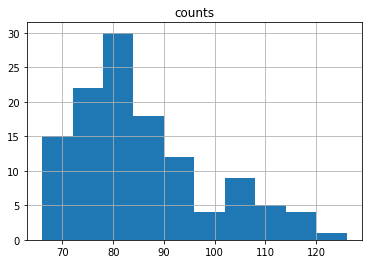

In [22]:
labels.groupby(['breed']).size().reset_index(name='counts').sort_values('counts', ascending=False).hist()

---
Ensure the sizes of the images are similar, or if not what are the sizes?

In [26]:
trainDims = {k: PIL.Image.open(k).size for k in trainFiles}

In [27]:
rowSizes, colSizes = list(zip(*trainDims.values()))
rowSizes = np.array(rowSizes)
colSizes = np.array(colSizes)

(array([3.798e+03, 6.259e+03, 1.080e+02, 1.800e+01, 1.100e+01, 4.000e+00, 1.900e+01, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

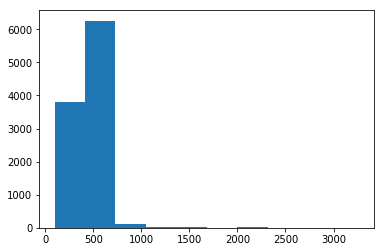

In [28]:
plt.hist(rowSizes)

(array([3.595e+03, 6.395e+03, 1.500e+02, 2.800e+01, 1.800e+01, 2.000e+01, 1.000e+01, 3.000e+00, 0.000e+00, 3.000e+00]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

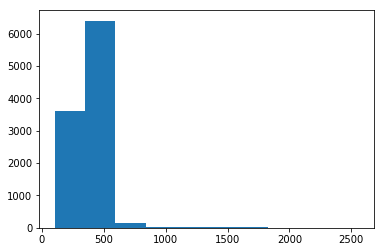

In [29]:
plt.hist(colSizes)

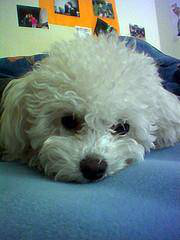

In [30]:
img = PIL.Image.open(trainFiles[0])
img

The image sizes seem reasonable, and we don't seem to have any gross disparities between the files that need to be resolved. 

# Create the model

## Set model creation parameters

In [31]:
# Set the size we want the images resized to
# Most of ImageNet models are trained on either 224 by 224 or 299 by 299 images
# We could also start with size 128, train, and then move to 224 to combat over fitting
imgSize = 224

# Batch size
# Remember to reduced this if a CUDA out of memory error occurs
batchSize = 32

# Seed value for similiar results accross multiple instances
seedVal = 10

## Define helper functions

## Create data collection

In [33]:
doc(ImageDataBunch)

In [41]:
doc(ImageItemList.label_from_df)

In [42]:
data = (ImageItemList.from_csv(path=PATH, csv_name='labels.csv', folder='train', suffix='.jpg')
        .random_split_by_pct(seed=seedVal)
        .label_from_df()
        .transform(get_transforms(), size=imgSize)
        .databunch(bs=batchSize)
        .normalize(imagenet_stats)
       )

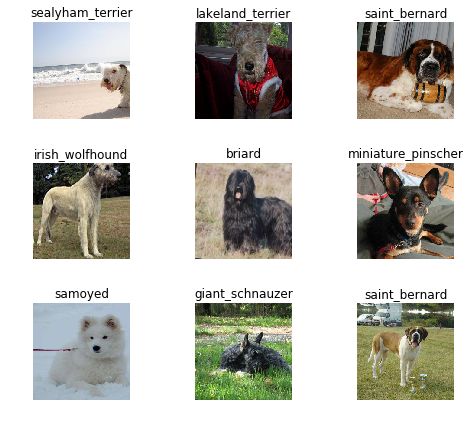

In [43]:
data.show_batch(rows=3, figsize=(7,6))

Confirm the data collection resulted in the same labels as the source data:

In [45]:
print(data.classes)
len(data.classes),data.c

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

(120, 120)

In [47]:
len(data.train_ds) + len(data.valid_ds)

10222

## Create model - resnet34

Next we'll create the model to be trained.

In [49]:
learn = create_cnn(data=data, arch=models.resnet34, metrics=error_rate)

In [50]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.838400,0.853490,0.256360
2,1.042972,0.600406,0.181996
3,0.816694,0.549080,0.169276
4,0.600003,0.514063,0.154599


In [56]:
learn.save('dogs_stage_1')

## Find best learning rate

We'll utilize the `lr_find()` function to determine what the optimal learning rate for the algorithm based on the data we're processing:

In [57]:
learn.lr_find(start_lr = 1e-9, end_lr = 1e-4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Visually inspect the optimal learning rate:

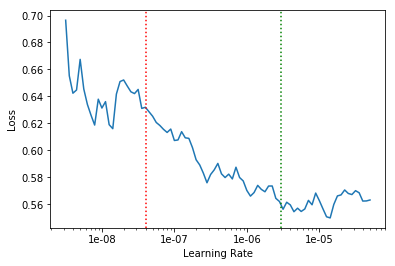

In [76]:
learn.recorder.plot()
plt.axvline(x=4e-8, color="r", linestyle=":")
plt.axvline(x=3e-6, color="g", linestyle=":")

In [79]:
# Set the learning rate for use during training
lr = slice(4e-8, 3e-6)

## Train last layer

In the beginning only the last layer of the model will be trained.  Because we are utilizing transfer learning from ReNet we don't want to lose all the pre-trained weights in the earlier layers.  We want to leverage and keep the already existing values from earlier in the network, and for now only fine tune the last layers to the features found in our specific images.

In [80]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr = lr)

epoch,train_loss,valid_loss,error_rate
1,0.602572,0.502459,0.154599
2,0.554393,0.504977,0.155088
3,0.556493,0.501134,0.148239
4,0.564431,0.505086,0.149217


In [83]:
learn.save("dogs_stage_2")

## Examine initial results

Let's examine how the model is doing so far.  This will provide validation the model is moving in the right direction, and if not corrective action can be taken.

In [82]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

### Most incorrect

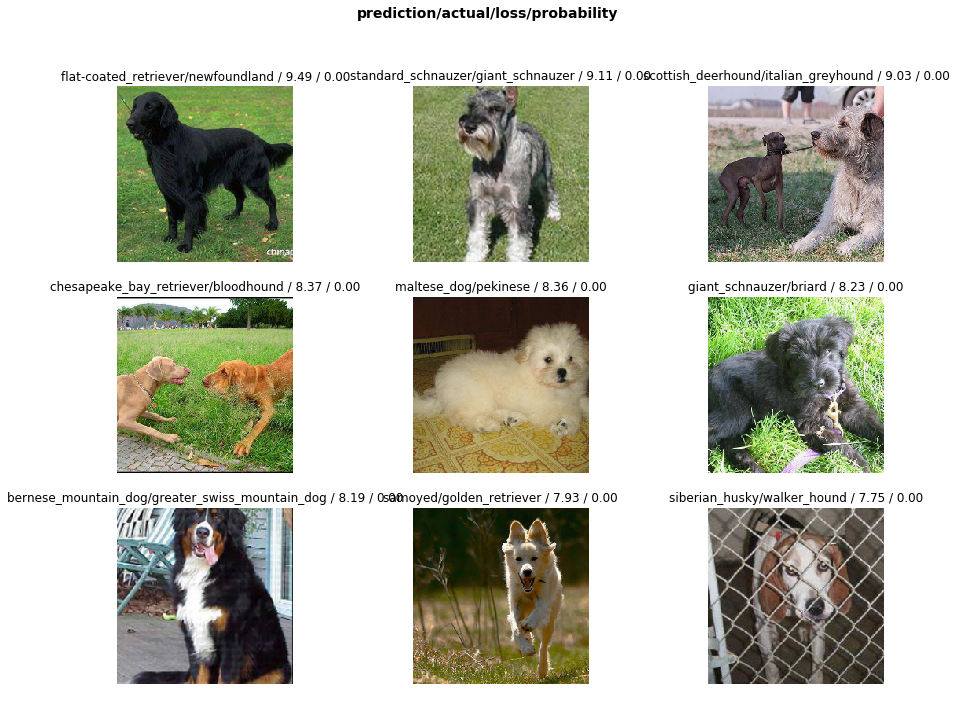

In [36]:
interp.plot_top_losses(9, figsize=(15,11))

### Labels wrong most often

In [37]:
interp.most_confused(min_val=2)

[('silky_terrier', 'australian_terrier', 8),
 ('walker_hound', 'english_foxhound', 8),
 ('collie', 'border_collie', 6),
 ('eskimo_dog', 'siberian_husky', 6),
 ('irish_wolfhound', 'scottish_deerhound', 5),
 ('lhasa', 'shih-tzu', 5),
 ('standard_schnauzer', 'miniature_schnauzer', 5),
 ('entlebucher', 'appenzeller', 4),
 ('eskimo_dog', 'malamute', 4),
 ('irish_terrier', 'airedale', 4),
 ('miniature_poodle', 'toy_poodle', 4),
 ('shetland_sheepdog', 'collie', 4),
 ('walker_hound', 'basset', 4),
 ('appenzeller', 'greater_swiss_mountain_dog', 3),
 ('beagle', 'english_foxhound', 3),
 ('black-and-tan_coonhound', 'rottweiler', 3),
 ('cardigan', 'pembroke', 3),
 ('entlebucher', 'greater_swiss_mountain_dog', 3),
 ('french_bulldog', 'boston_bull', 3),
 ('german_shepherd', 'malinois', 3),
 ('miniature_poodle', 'standard_poodle', 3),
 ('miniature_schnauzer', 'standard_schnauzer', 3),
 ('norfolk_terrier', 'australian_terrier', 3),
 ('siberian_husky', 'eskimo_dog', 3),
 ('siberian_husky', 'malamute', 3

So these appear to be breeds that would likely also be misclassified by a human, which is a good indication the model isn't completely missing the mark on obvious items.  Since the model appears to be functioning correctly we'll proceed with further training.

## Recheck learning rate

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


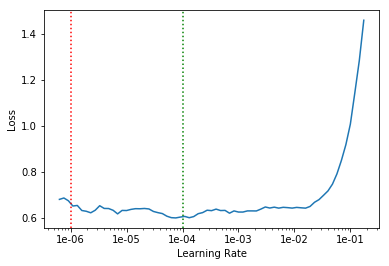

In [73]:
learn.recorder.plot()
plt.axvline(x=1e-6, color="r", linestyle=":")
plt.axvline(x=1e-4, color="g", linestyle=":")

In [38]:
# Set the learning rate for use during training
lr = slice(1e-6,1e-4)

## Train full network

In [39]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.655167,0.588839,0.176125
2,0.609791,0.575116,0.170744
3,0.585011,0.562020,0.177104
4,0.519696,0.559924,0.172701


In [40]:
learn.save("full_resnet34_224")

In [41]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.572252,0.573006,0.165362
2,0.525038,0.565126,0.167808


In [44]:
learn.save("full_resnet34_224_2")

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [42]:
learn.save("final_resnet34_224")

# Predictions

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

## Most incorrect

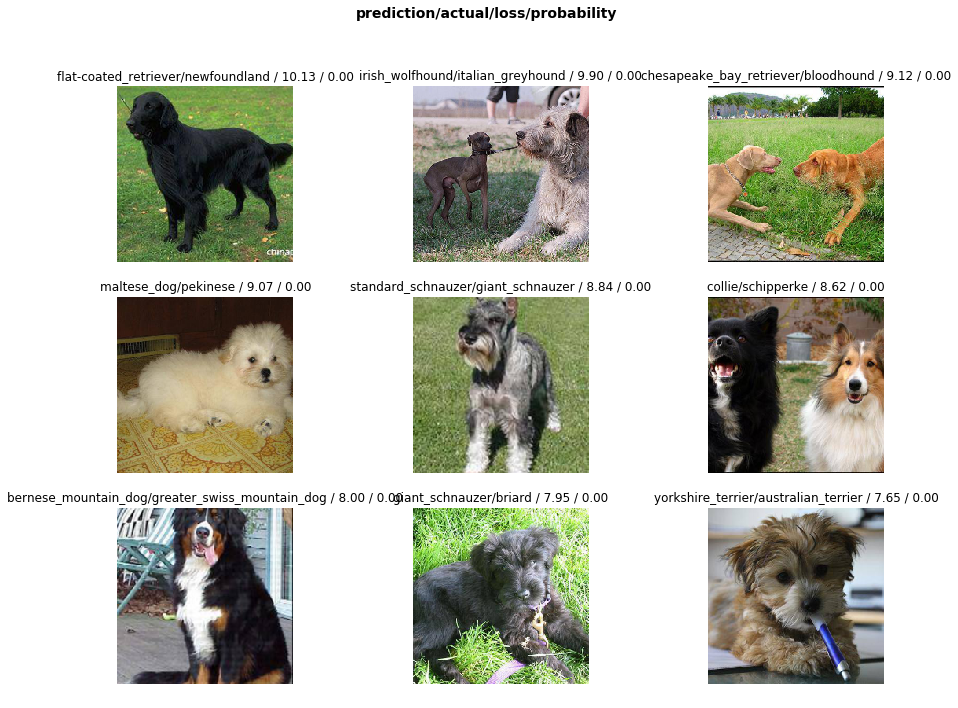

In [47]:
interp.plot_top_losses(9, figsize=(15,11))

### Labels wrong most often

In [48]:
interp.most_confused(min_val=2)

[('collie', 'border_collie', 6),
 ('entlebucher', 'appenzeller', 6),
 ('eskimo_dog', 'siberian_husky', 6),
 ('irish_wolfhound', 'scottish_deerhound', 6),
 ('walker_hound', 'english_foxhound', 6),
 ('miniature_poodle', 'standard_poodle', 5),
 ('miniature_poodle', 'toy_poodle', 5),
 ('silky_terrier', 'australian_terrier', 5),
 ('eskimo_dog', 'malamute', 4),
 ('lakeland_terrier', 'wire-haired_fox_terrier', 4),
 ('lhasa', 'shih-tzu', 4),
 ('cardigan', 'pembroke', 3),
 ('french_bulldog', 'boston_bull', 3),
 ('german_shepherd', 'malinois', 3),
 ('miniature_schnauzer', 'standard_schnauzer', 3),
 ('shetland_sheepdog', 'collie', 3),
 ('siberian_husky', 'eskimo_dog', 3),
 ('siberian_husky', 'malamute', 3)]

# Create Kaggle submission

And finally create and submit the predictions from the model against the test set to Kaggle for scoring:

In [124]:
imgs = ImageItemList.from_folder(PATH + '/test')
learn.export()
inf = load_learner(learn.path, test=imgs)

In [125]:
preds,y = inf.TTA(ds_type=DatasetType.Test)

In [58]:
#preds,y = inf.get_preds(ds_type=DatasetType.Test,)

In [126]:
# Sanity check
preds.shape 

torch.Size([10357, 120])

In [116]:
# Sanity check
preds.shape 

torch.Size([10357, 120])

In [127]:
len(preds)

10357

In [60]:
len(preds)

10357

In [128]:
preds[0]

tensor([5.4407e-08, 3.3207e-05, 1.3023e-06, 2.2561e-07, 2.9834e-08, 2.8579e-08,
        5.8714e-07, 1.3615e-07, 5.6748e-08, 2.8828e-09, 1.3661e-06, 7.8308e-07,
        1.5092e-07, 2.9605e-09, 7.9675e-08, 4.1300e-07, 1.6644e-05, 2.3643e-08,
        4.2819e-06, 7.7990e-09, 7.5314e-05, 6.4156e-09, 7.3704e-09, 5.4174e-04,
        2.2246e-08, 8.9986e-09, 9.8522e-06, 9.2154e-08, 1.6098e-08, 3.9339e-09,
        7.3371e-08, 1.5910e-08, 1.7246e-08, 4.9321e-06, 6.0087e-08, 1.7670e-06,
        8.4387e-08, 7.4233e-08, 2.0723e-07, 6.7059e-08, 5.7995e-08, 4.6893e-09,
        2.2230e-07, 2.8350e-07, 5.4787e-06, 3.7761e-09, 1.4748e-06, 9.3659e-08,
        9.5507e-05, 6.8803e-08, 1.3171e-07, 3.4966e-06, 1.0451e-05, 1.0261e-07,
        5.7829e-06, 1.9288e-06, 9.2750e-07, 3.8321e-06, 9.8757e-08, 1.3740e-01,
        1.8444e-07, 3.1719e-08, 1.0120e-05, 4.6374e-07, 1.3902e-07, 6.7108e-04,
        1.4013e-07, 1.9115e-08, 1.5751e-07, 5.2139e-07, 2.5604e-07, 1.4620e-07,
        3.1172e-08, 2.6347e-07, 1.5302e-

In [59]:
preds[0]

tensor([6.6941e-09, 3.0279e-05, 5.9681e-07, 1.9903e-07, 3.1815e-09, 6.2116e-09,
        1.1892e-07, 4.7170e-08, 3.2643e-08, 4.3803e-10, 2.6776e-07, 2.2861e-07,
        8.5194e-08, 3.4563e-10, 3.0038e-08, 1.2121e-07, 2.1100e-06, 4.4735e-09,
        1.4979e-06, 2.0278e-09, 4.9514e-05, 2.4940e-09, 1.5350e-09, 2.7824e-04,
        4.5572e-09, 2.3062e-09, 2.6702e-06, 1.6687e-08, 2.2132e-09, 8.0051e-10,
        4.4844e-09, 2.6508e-09, 7.0134e-09, 5.8433e-07, 1.1976e-08, 1.2540e-06,
        9.3022e-09, 8.4282e-09, 7.7870e-08, 6.1009e-09, 1.4908e-08, 7.1766e-10,
        5.9173e-08, 2.4443e-08, 1.5939e-06, 8.4295e-10, 9.0692e-07, 1.4248e-08,
        1.1828e-04, 2.6386e-08, 3.6474e-08, 4.4738e-06, 2.2016e-06, 2.6032e-08,
        5.3537e-07, 5.5617e-07, 4.4562e-07, 3.2805e-06, 2.4061e-08, 1.9995e-01,
        5.2124e-08, 7.8837e-09, 2.4228e-06, 6.6644e-08, 4.7994e-08, 1.9962e-05,
        1.4591e-08, 8.5500e-09, 3.4232e-08, 2.1502e-07, 8.2993e-08, 4.6362e-08,
        1.0794e-08, 5.1364e-08, 3.8551e-

In [129]:
# Create Pandas dataframe to hold submission results
df = pd.DataFrame(preds.numpy())

# One column for each class (i.e. 120)
df.columns = data.classes

In [130]:
# Strip off the folder name and file extension from the image file names and add to dataframe
df.insert(0, 'id', [o.name[:-4] for o in imgs.items])

In [131]:
# Examine some results
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,de084b830010b6107215fef5d4a75b94,5.440658e-08,0.000033,1.302258e-06,2.256075e-07,2.983358e-08,2.857857e-08,5.871360e-07,1.361461e-07,5.674798e-08,...,8.189203e-09,4.803857e-09,1.411626e-07,4.090660e-08,6.135316e-07,3.243838e-07,3.862901e-07,0.000016,1.885647e-07,5.845990e-08
1,6b423ca7020e70eb05732843c5d2bad1,2.204762e-04,0.000037,1.101245e-05,5.272914e-05,5.026957e-06,2.500030e-06,2.022682e-06,2.009172e-06,6.501823e-06,...,6.695680e-07,4.126153e-07,4.608218e-07,2.850148e-06,2.249279e-07,7.001446e-06,2.136171e-05,0.000018,8.409610e-05,1.267858e-06
2,74aa7e201e0e93e13e87b986a7d31839,3.540753e-05,0.000033,8.474189e-06,1.178468e-01,7.791929e-06,1.295349e-05,2.340788e-05,2.613333e-05,2.468868e-06,...,6.360415e-04,1.239102e-05,4.248669e-05,8.862380e-06,2.876562e-06,1.888905e-05,8.885310e-06,0.000008,4.102570e-02,3.472417e-05
3,a079f72193264bc5685e5d28d7372680,5.435281e-04,0.000003,3.942943e-06,4.318227e-06,3.808733e-06,6.007244e-06,2.656499e-05,3.905780e-06,7.053504e-07,...,2.896507e-06,5.675316e-05,4.074819e-07,7.174317e-07,4.208293e-07,4.631072e-06,5.894745e-05,0.000005,4.959530e-04,1.526830e-04
4,583f7580fa5fec1266331fcf83b76fd6,1.508205e-04,0.000098,9.577930e-07,7.536852e-05,2.681026e-06,3.887997e-06,2.205553e-07,2.785446e-06,4.810230e-07,...,3.263447e-05,1.702404e-06,2.337397e-07,2.913533e-06,3.764725e-07,8.681882e-06,1.258428e-05,0.000004,7.572420e-05,3.471544e-06


In [132]:
# Write submission file to disk
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [133]:
# Provide link to download submission file
from IPython.display import FileLink
FileLink(f'{SUBM}subm.gz')

/home/paperspace/Portfolio/Machine-Learning/Python/03-ComputerVision-Classification/data/dogbreeds/subm/subm.gz

---
The results:

Kaggle score:  0.41982

Since I have a new GPU arriving we'll take this write-up and run it again against a larger architecture (ResNet-50 and/or ResNet-101), and we can examine what sort of impact that has on the Kaggle scoring.  Also remember that the lower the Kaggle score the better due to the method of assement (i.e. Multi Class Log Loss).